In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import atlite
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import xesmf as xe

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [5]:
from bias_correction import bias_factor_era5_sarah
bias_factor_era5_sarah_rsdsdiff= bias_factor_era5_sarah('influx_diffuse') #bias factor in 0.3x0.3

['/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc', '/groups/EXTREMES/cutouts/europe-2012-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2012-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc']
189 190
157 158
157 158
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


In [8]:
from regridding_functions import read_and_average_era5_marta
from regridding_functions import read_and_average_cmip
rsdsdiff_era5_mean_BOC= read_and_average_era5_marta('influx_diffuse') #mean of era5 historical period for each grid cell
rsdsdiff_model_mean_BOC= read_and_average_cmip("/SFCRAD/CMCC-CM2-SR5/historical/r1i1p1f1/", 'rsdsdiff') #mean of model of historical period for each grid cell

['/groups/EXTREMES/cutouts/europe-1980-era5.nc', '/groups/EXTREMES/cutouts/europe-1981-era5.nc', '/groups/EXTREMES/cutouts/europe-1982-era5.nc', '/groups/EXTREMES/cutouts/europe-1983-era5.nc', '/groups/EXTREMES/cutouts/europe-1984-era5.nc', '/groups/EXTREMES/cutouts/europe-1985-era5.nc', '/groups/EXTREMES/cutouts/europe-1986-era5.nc', '/groups/EXTREMES/cutouts/europe-1987-era5.nc', '/groups/EXTREMES/cutouts/europe-1988-era5.nc', '/groups/EXTREMES/cutouts/europe-1989-era5.nc', '/groups/EXTREMES/cutouts/europe-1990-era5.nc', '/groups/EXTREMES/cutouts/europe-1991-era5.nc', '/groups/EXTREMES/cutouts/europe-1992-era5.nc', '/groups/EXTREMES/cutouts/europe-1993-era5.nc', '/groups/EXTREMES/cutouts/europe-1994-era5.nc', '/groups/EXTREMES/cutouts/europe-1995-era5.nc', '/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-1997-era5.nc', '/groups/EXTREMES/cutouts/europe-1998-era5.nc', '/groups/EXTREMES/cutouts/europe-1999-era5.nc', '/groups/EXTREMES/cutouts/europe-2000-e

In [9]:
rsdsdiff_era5_mean_BOC=rsdsdiff_era5_mean_BOC.sel(x=slice(-12, 35), y=slice(33, 72))
rsdsdiff_model_mean_BOC=rsdsdiff_model_mean_BOC.sel(lon=slice(-12, 35), lat=slice(33, 72))

In [13]:
from regridding_functions import regrid
ds_03 = xr.open_dataset('europe_03.nc')  # grid 0.3x0.3
regridder_era5 = regrid(rsdsdiff_era5_mean_BOC, ds_03, method='conservative')  # regrid era5 to the 0.3x0.3º grid
rsdsdiff_era5_03 = regridder_era5(rsdsdiff_era5_mean_BOC)  # regridded historical mean from era5 to 0.3x0.3º grid
rsdsdiff_era5_correct = rsdsdiff_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 72)) * bias_factor_era5_sarah_rsdsdiff  # apply bias factor to era5 rsds
regridder_era503_model = regrid(rsdsdiff_era5_correct, rsdsdiff_model_mean_BOC, method='conservative')  # regrid corrected era5 to the model grid
rsdsdiff_era5_correct_model = regridder_era503_model(rsdsdiff_era5_correct)  # regrid corrected era5 to the model grid
rsdsdiff_era5_correct_model = rsdsdiff_era5_correct_model.sel(lon=slice(-12, 35), lat=slice(33, 72))

189 190
157 158
157 158
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


157 158
131 132
38 39
41 42


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(


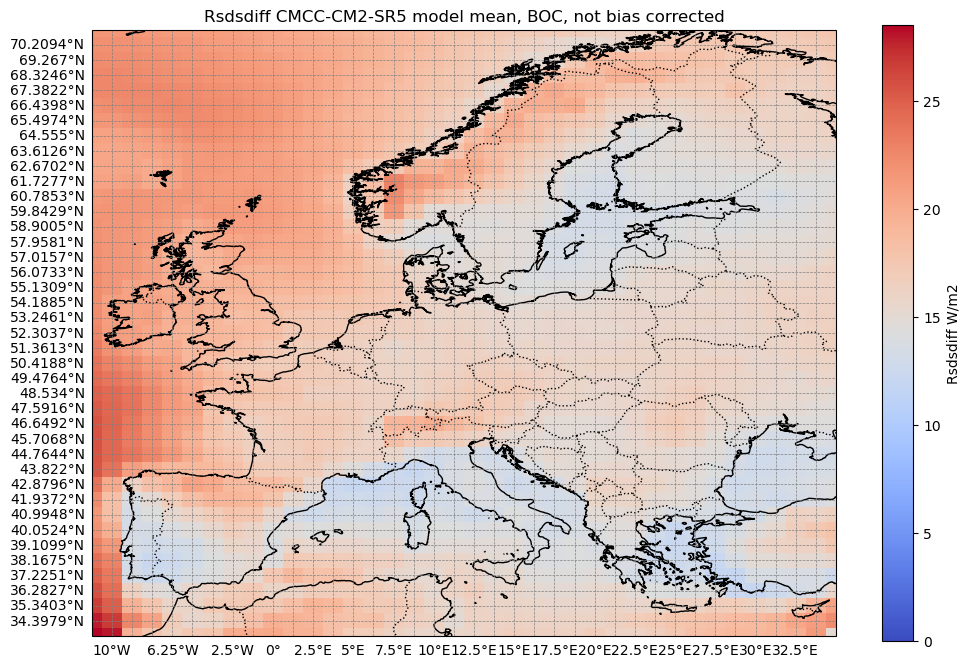

In [ ]:
# Get lat/lon values
lon = rsdsdiff_model_mean_BOC.lon.values 
lat = rsdsdiff_model_mean_BOC.lat.values

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsdsdiff_model_mean_BOC.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsdsdiff_model_mean_BOC.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, rsdsdiff_model_mean_BOC,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto' ,
    vmin=0 
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Rsdsdiff CMCC-CM2-SR5 model mean, BOC, not bias corrected")

# Add gridlines for each latitude and longitude
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=rsdsdiff_model_mean_BOC.lon, 
    ylocs=rsdsdiff_model_mean_BOC.lat, 
    x_inline=False, 
    y_inline=False
)

# Configure gridline labels
gridlines.right_labels = False  # Disable latitude labels on the right
gridlines.left_labels = True    # Enable latitude labels on the left
gridlines.top_labels = False    # Disable longitude labels on the top
gridlines.bottom_labels = True  # Enable longitude labels on the bottom
# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Rsdsdiff W/m2')

plt.show() 

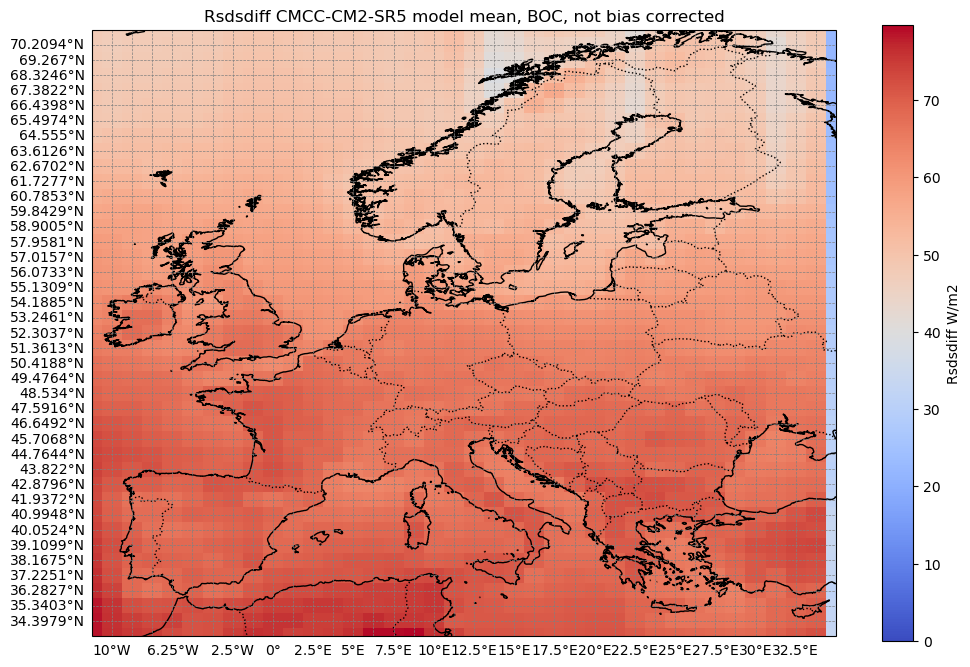

In [17]:
# Get lat/lon values
lon = rsdsdiff_model_mean_BOC.lon.values 
lat = rsdsdiff_model_mean_BOC.lat.values

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsdsdiff_model_mean_BOC.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsdsdiff_model_mean_BOC.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, rsdsdiff_era5_correct_model,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto' ,
    vmin=0 
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Rsdsdiff Era5, not bias corrected")

# Add gridlines for each latitude and longitude
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=rsdsdiff_model_mean_BOC.lon, 
    ylocs=rsdsdiff_model_mean_BOC.lat, 
    x_inline=False, 
    y_inline=False
)

# Configure gridline labels
gridlines.right_labels = False  # Disable latitude labels on the right
gridlines.left_labels = True    # Enable latitude labels on the left
gridlines.top_labels = False    # Disable longitude labels on the top
gridlines.bottom_labels = True  # Enable longitude labels on the bottom
# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Rsdsdiff W/m2')

plt.show() 

In [18]:
# Assuming these variables exist
numerator_era5= rsdsdiff_era5_correct_model.values  # ERA5 dataset
denominator_era5_model= rsdsdiff_model_mean_BOC.values  # SARAH dataset

# Ensure valid bias factor calc
# ulation
mask_valid = (numerator_era5 != 0) & (denominator_era5_model != 0) # Avoid division by zero and all values in sarah that have mean 0
bias_factor_era5_model = np.where(mask_valid, numerator_era5 / denominator_era5_model, np.nan)  # Replace invalid cases with NaN

In [20]:
bias_factor_era5_model

array([[2.7574794, 2.7265642, 3.8132472, ..., 3.5717528, 3.3895729,
        2.2255592],
       [2.818831 , 2.8334131, 3.2824202, ..., 3.3936052, 3.305337 ,
        1.4835495],
       [2.926023 , 3.0254302, 3.7133672, ..., 4.0244975, 3.6458569,
        1.5701199],
       ...,
       [2.1460118, 2.1351173, 2.1698258, ..., 2.6896238, 2.8532085,
        1.2863727],
       [2.1555374, 2.1405075, 2.175907 , ..., 2.6548083, 2.7772439,
        1.2626554],
       [2.1966298, 2.1843739, 2.2039824, ..., 2.6110814, 2.7387466,
        1.2441406]], dtype=float32)

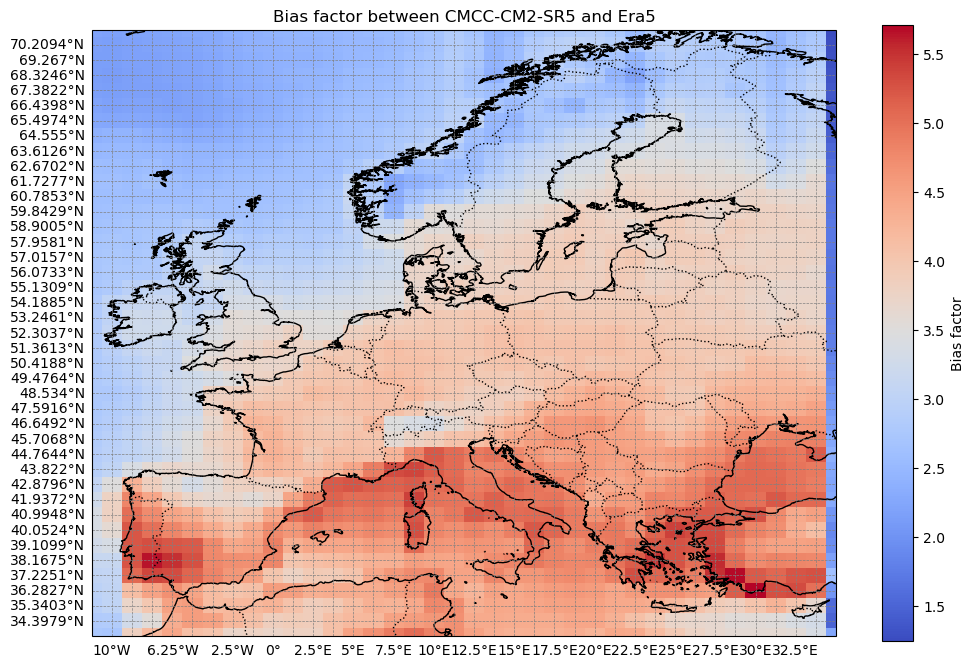

In [22]:
# Get lat/lon values
lon = rsdsdiff_model_mean_BOC.lon.values 
lat = rsdsdiff_model_mean_BOC.lat.values

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsdsdiff_model_mean_BOC.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsdsdiff_model_mean_BOC.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, bias_factor_era5_model,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto' ,
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Bias factor between CMCC-CM2-SR5 and Era5")

# Add gridlines for each latitude and longitude
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=rsdsdiff_model_mean_BOC.lon, 
    ylocs=rsdsdiff_model_mean_BOC.lat, 
    x_inline=False, 
    y_inline=False
)

# Configure gridline labels
gridlines.right_labels = False  # Disable latitude labels on the right
gridlines.left_labels = True    # Enable latitude labels on the left
gridlines.top_labels = False    # Disable longitude labels on the top
gridlines.bottom_labels = True  # Enable longitude labels on the bottom
# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias factor')

plt.show() 